## POS tagging using modified Viterbi

We will modify vanilla Viterbi algorithm to tackle problem arising because of unknown words

### Exploring Universal tag set
1. Create Treebank dataset of NLTK with the 'universal' tagset
   - Perform text and structure exploration
2. Creating HMM model on the tagged data set.
   - Calculating Emission Probabaility: P(observation|state)
   - Calculating Transition Probability: P(state2|state1)


### Develop Viterbi Heuristic
1. POS Tagging Algorithm - HMM
2. Developing algorithm for vanilla Viterbi Heuristic
3. Checking accuracy on the test data set


### Solve the problem of unknown words
1. Modifying vanilla Viterbi Heuristic based on sound observation (First technique)
2. Checking accuracy on the test data set of the first technique
3. Modifying vanilla Viterbi Heuristic based on sound observation (Second technique)
4. Checking accuracy on the test data set of the second technique

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

Compare the tagging accuacies from the above techniques with vanilla Viterbi algorithm

### List down cases which were incorrectly tagged by original POS tagger and got corrected by modifications

1. Read the text file provided in this assignment and run it against different algorithms. 
2. List down the cases which were incorrectly tagged and then corrected by modified Viterbi algorithm

## 1. Exploring Universal tag set

### Data Preparation

In [1]:
#Importing libraries
import nltk
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import math
import time
import numpy as np
import pandas as pd
import collections
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# reading the universal tag set
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
len(nltk_data)

3914

In [4]:
# first few tagged sentences
nltk_data[:3]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')],
 [('Rudolph', 'NOUN'),
  ('Agnew', 'NOUN'),
  (',', '.'),
  ('55', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  ('and', 'CONJ'),
  ('former', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Consolidated', 'NOUN'),
  ('Gold', 'NOUN'),
  ('Fields', 'NOUN'),
  ('PLC', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('named', 'VERB'),
  ('*-1', 'X'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
 

In [5]:
# Splitting into train and test in a ratio of 95:5
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:40])

3718
196
[[('Over', 'ADP'), ('50', 'NUM'), ('witnesses', 'NOUN'), (',', '.'), ('mostly', 'ADV'), ('students', 'NOUN'), (',', '.'), ('were', 'VERB'), ('interviewed', 'VERB'), ('*-1', 'X'), ('.', '.')], [('When', 'ADV'), ('*', 'X'), ('referred', 'VERB'), ('*-2', 'X'), ('to', 'PRT'), ('the', 'DET'), ('questions', 'NOUN'), ('that', 'DET'), ('*T*-107', 'X'), ('matched', 'VERB'), ('*T*-1', 'X'), (',', '.'), ('he', 'PRON'), ('said', 'VERB'), ('0', 'X'), ('it', 'PRON'), ('was', 'VERB'), ('coincidental', 'ADJ'), ('.', '.')], [('The', 'DET'), ('recent', 'ADJ'), ('cash', 'NOUN'), ('squeeze', 'NOUN'), ('at', 'ADP'), ('Campeau', 'NOUN'), ('Corp.', 'NOUN'), (',', '.'), ('First', 'NOUN'), ('Boston', 'NOUN'), ("'s", 'PRT'), ('most', 'ADJ'), ('lucrative', 'ADJ'), ('client', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('decade', 'NOUN'), (',', '.'), ('is', 'VERB'), ('proving', 'VERB'), ('costly', 'ADJ'), ('to', 'PRT'), ('First', 'NOUN'), ('Boston', 'NOUN'), ('because', 'ADP'), ('it', 'PRON'), ('arranged', '

In [6]:
# Getting list of tagged words
# converting the list of sents to a list of (word, pos tag) tuples
train_tagged_words = [tup for sent in train_set for tup in sent]
print(len(train_tagged_words))

95745


In [7]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Over',
 '50',
 'witnesses',
 ',',
 'mostly',
 'students',
 ',',
 'were',
 'interviewed',
 '*-1']

In [8]:
# vocabulary
V = set(tokens)
print(len(V))

12059


In [9]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [10]:
print(T)

{'ADP', 'VERB', 'PRT', 'NUM', '.', 'PRON', 'CONJ', 'DET', 'X', 'ADJ', 'ADV', 'NOUN'}


### As you can clearly see the unknown tags will be tagged with 'ADP' as it is first in the set when this script was run. The reason is the first sentence used in training data, had first word tagged to ('Although', 'ADP')

## 2. Develop Viterbi Heuristic

### 1. POS Tagging Algorithm - HMM

We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. 

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).


P(w/t) is basically the probability that given a tag (say NN), what is the probability of it being w (say 'building'). This can be computed by computing the fraction of all NNs which are equal to w, i.e. 

P(w/t) = count(w, t) / count(t). 


The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).


Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero. 


### Emission Probabilities

In [11]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [12]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [13]:
# examples

# first
print("\n", "first")
print(word_given_tag('large', 'ADJ'))
print(word_given_tag('large', 'ADV'))
print(word_given_tag('large', 'DET'), "\n")

# will
print("\n", "will")
print(word_given_tag('will', 'VERB'))
print(word_given_tag('will', 'NOUN'))

# book
print("\n", "book")
print(word_given_tag('book', 'NOUN'))
print(word_given_tag('book', 'VERB'))

# Android
print("\n", "Android")
print(word_given_tag('Android', 'NOUN'))
print(word_given_tag('Android', 'VERB'))



 first
(27, 6061)
(0, 2990)
(0, 8288) 


 will
(260, 12901)
(1, 27471)

 book
(7, 27471)
(1, 12901)

 Android
(0, 27471)
(0, 12901)


### Transition Probabilities

In [14]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [15]:
# examples
print(t2_given_t1(t2='NOUN', t1='ADJ'))
print(t2_given_t1('DET', 'NOUN'))
print(t2_given_t1('NOUN', 'NOUN'))
print(t2_given_t1('VERB', 'NOUN'))

(4245, 6061)
(366, 27471)
(7279, 27471)
(4013, 27471)


In [16]:
#Please note P(tag|start) is same as P(tag|'.')
print(t2_given_t1('DET', '.'))
print(t2_given_t1('VERB', '.'))
print(t2_given_t1('NOUN', '.'))

(1945, 11169)
(999, 11169)
(2456, 11169)


In [17]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [18]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df.head()

,ADP,VERB,PRT,NUM,.,PRON,CONJ,DET,X,ADJ,ADV,NOUN
ADP,0.017398,0.008219,0.001388,0.063187,0.040453,0.067670,0.000747,0.322660,0.035223,0.106095,0.013555,0.323407
VERB,0.089916,0.169909,0.031703,0.023487,0.034183,0.036121,0.005348,0.134641,0.218510,0.064801,0.080846,0.110534
PRT,0.020595,0.401438,0.001635,0.057862,0.042498,0.017980,0.002288,0.097744,0.013403,0.085976,0.009807,0.248774
NUM,0.035322,0.017216,0.027011,0.184921,0.111903,0.001484,0.013654,0.003265,0.211636,0.034135,0.002968,0.356486
.,0.090787,0.089444,0.002507,0.080491,0.094100,0.066255,0.058018,0.174143,0.027039,0.044677,0.052556,0.219894


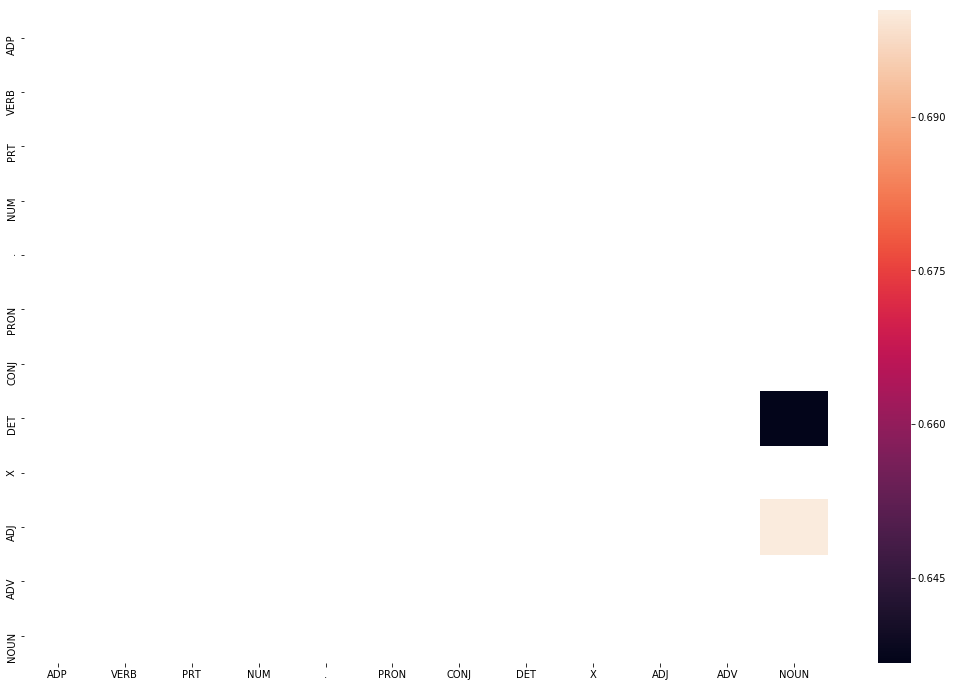

In [19]:
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

### Build the vanilla Viterbi based POS tagger

In [20]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

#### Please note here ADP has been assigned as default tag for unknown words as explained above.

In [21]:
# Running on entire test dataset would take more time. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('He', 'PRON'),
  ('also', 'ADV'),
  ('asserted', 'VERB'),
  ('that', 'ADP'),
  ('exact', 'ADJ'),
  ('questions', 'NOUN'),
  ('were', 'VERB'),
  ("n't", 'ADV'),
  ('replicated', 'VERB'),
  ('*-1', 'X'),
  ('.', '.')],
 [('The', 'DET'),
  ('reaction', 'NOUN'),
  ('in', 'ADP'),
  ('the', 'DET'),
  ('newsroom', 'NOUN'),
  ('was', 'VERB'),
  ('emotional', 'ADJ'),
  ('.', '.')],
 [('Many', 'ADJ'),
  ('banks', 'NOUN'),
  (',', '.'),
  ('particularly', 'ADV'),
  ('smaller', 'ADJ'),
  ('ones', 'NOUN'),
  (',', '.'),
  ('were', 'VERB'),
  ('slow', 'ADJ'),
  ('*-1', 'X'),
  ('to', 'PRT'),
  ('computerize', 'VERB'),
  ('and', 'CONJ'),
  ('could', 'VERB'),
  ("n't", 'ADV'),
  ('target', 'VERB'),
  ('market', 'NOUN'),
  ('niches', 'NOUN'),
  ('that', 'DET'),
  ('*T*-199', 'X'),
  ('would', 'VERB'),
  ('have', 'VERB'),
  ('made', 'VERB'),
  ('the', 'DET'),
  ('programs', 'NOUN'),
  ('more', 'ADV'),
  ('profitable', 'ADJ'),
  ('.', '.')],
 [('But', 'CONJ'),
  ('with', 'ADP'),
  ('the', 'DET'),
  ('

In [22]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [23]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  21.749807834625244
[('He', 'PRON'), ('also', 'ADV'), ('asserted', 'VERB'), ('that', 'DET'), ('exact', 'ADJ'), ('questions', 'NOUN'), ('were', 'VERB'), ("n't", 'ADV'), ('replicated', 'ADP'), ('*-1', 'X'), ('.', '.'), ('The', 'DET'), ('reaction', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('newsroom', 'NOUN'), ('was', 'VERB'), ('emotional', 'ADP'), ('.', '.'), ('Many', 'ADJ'), ('banks', 'NOUN'), (',', '.'), ('particularly', 'ADV'), ('smaller', 'ADJ'), ('ones', 'NOUN'), (',', '.'), ('were', 'VERB'), ('slow', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('computerize', 'ADP'), ('and', 'CONJ'), ('could', 'VERB'), ("n't", 'ADV'), ('target', 'VERB'), ('market', 'NOUN'), ('niches', 'ADP'), ('that', 'DET'), ('*T*-199', 'ADP'), ('would', 'VERB'), ('have', 'VERB'), ('made', 'VERB'), ('the', 'DET'), ('programs', 'NOUN'), ('more', 'ADV'), ('profitable', 'ADJ'), ('.', '.'), ('But', 'CONJ'), ('with', 'ADP'), ('the', 'DET'), ('index', 'NOUN'), ('proving', 'VERB'), ('somewhat', 'ADV'), ('

In [24]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [25]:
incorrect_tagged_cases

[[('asserted', 'VERB'), (('that', 'DET'), ('that', 'ADP'))],
 [("n't", 'ADV'), (('replicated', 'ADP'), ('replicated', 'VERB'))],
 [('was', 'VERB'), (('emotional', 'ADP'), ('emotional', 'ADJ'))],
 [('were', 'VERB'), (('slow', 'VERB'), ('slow', 'ADJ'))],
 [('to', 'PRT'), (('computerize', 'ADP'), ('computerize', 'VERB'))],
 [('market', 'NOUN'), (('niches', 'ADP'), ('niches', 'NOUN'))],
 [('that', 'DET'), (('*T*-199', 'ADP'), ('*T*-199', 'X'))],
 [('somewhat', 'ADV'), (('better', 'ADV'), ('better', 'ADJ'))],
 [('anticipated', 'VERB'), (('report', 'VERB'), ('report', 'NOUN'))],
 [('to', 'PRT'), (('arrive', 'ADP'), ('arrive', 'VERB'))],
 [('prices', 'NOUN'), (('firmed', 'ADP'), ('firmed', 'VERB'))],
 [('then', 'ADV'), (('faltered', 'ADP'), ('faltered', 'VERB'))],
 [('solid', 'ADJ'), (('382-37', 'ADP'), ('382-37', 'NUM'))]]

In [26]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [27]:
accuracy = len(check)/len(tagged_seq)

In [28]:
accuracy

0.8907563025210085

### 3. Checking accuracy on the test data set

In [29]:
# Lets run it on the test data set
test_run_base = [tup for sent in test_set for tup in sent]

test_tagged_words = [tup[0] for sent in test_set for tup in sent]
len(test_tagged_words)

4931

In [30]:
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [31]:
print("Time taken in seconds: ", difference)
# print(tagged_seq)
# print(test_run_base)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('accuracy=',accuracy) 

Time taken in seconds:  762.1802985668182
accuracy= 0.8963699046846482


## 3. Solve the problem of unknown words

As we can see in the previous section where we took few sentences for POS tagging, few words are tagged to '.' 

Root cause:
When vanilla Viterbi algorithm encouters unknown tags, emission probability of those words would be 0.<br />
As a result, state_probability becomes 0 [emission_p * transition_p]<br />
The tag assigned from tag list would be '.' as it is the first tag. <br />

### First technique using Lexicon method
#### Lets assign most common tag to unknown words, this is nothing but lexicon based approach. By default Viterbi algorithm assigns ADP as default as it is the first POS tag. We will find out the most common tag and assign it to the unknown words.

In [32]:
# first POS tag is 'ADP'
print(T)

{'ADP', 'VERB', 'PRT', 'NUM', '.', 'PRON', 'CONJ', 'DET', 'X', 'ADJ', 'ADV', 'NOUN'}


In [33]:
# Most commonly assigned tag is 'NOUN' tag
tag_list = list([pair[1] for pair in train_tagged_words])
tag_list_counter=collections.Counter(tag_list)
print(tag_list_counter.most_common(5))

[('NOUN', 27471), ('VERB', 12901), ('.', 11169), ('ADP', 9369), ('DET', 8288)]


In [34]:
# Viterbi Heuristic updated with only transition probability if emission probabbility is 0
def Viterbi_updated_with_lexicon(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        if pmax == 0:
            state_max = 'NOUN'
        else:
            state_max = T[p.index(pmax)]
            
        # getting state for which probability is maximum
        state.append(state_max)
    return list(zip(words, state))

In [35]:
random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('He', 'PRON'),
  ('also', 'ADV'),
  ('asserted', 'VERB'),
  ('that', 'ADP'),
  ('exact', 'ADJ'),
  ('questions', 'NOUN'),
  ('were', 'VERB'),
  ("n't", 'ADV'),
  ('replicated', 'VERB'),
  ('*-1', 'X'),
  ('.', '.')],
 [('The', 'DET'),
  ('reaction', 'NOUN'),
  ('in', 'ADP'),
  ('the', 'DET'),
  ('newsroom', 'NOUN'),
  ('was', 'VERB'),
  ('emotional', 'ADJ'),
  ('.', '.')],
 [('Many', 'ADJ'),
  ('banks', 'NOUN'),
  (',', '.'),
  ('particularly', 'ADV'),
  ('smaller', 'ADJ'),
  ('ones', 'NOUN'),
  (',', '.'),
  ('were', 'VERB'),
  ('slow', 'ADJ'),
  ('*-1', 'X'),
  ('to', 'PRT'),
  ('computerize', 'VERB'),
  ('and', 'CONJ'),
  ('could', 'VERB'),
  ("n't", 'ADV'),
  ('target', 'VERB'),
  ('market', 'NOUN'),
  ('niches', 'NOUN'),
  ('that', 'DET'),
  ('*T*-199', 'X'),
  ('would', 'VERB'),
  ('have', 'VERB'),
  ('made', 'VERB'),
  ('the', 'DET'),
  ('programs', 'NOUN'),
  ('more', 'ADV'),
  ('profitable', 'ADJ'),
  ('.', '.')],
 [('But', 'CONJ'),
  ('with', 'ADP'),
  ('the', 'DET'),
  ('

In [36]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_updated_with_lexicon(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)


# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

accuracy = len(check)/len(tagged_seq)

accuracy

Time taken in seconds:  18.156716346740723


0.8907563025210085

In [37]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

incorrect_tagged_cases

[[('asserted', 'VERB'), (('that', 'DET'), ('that', 'ADP'))],
 [("n't", 'ADV'), (('replicated', 'NOUN'), ('replicated', 'VERB'))],
 [('was', 'VERB'), (('emotional', 'NOUN'), ('emotional', 'ADJ'))],
 [('were', 'VERB'), (('slow', 'VERB'), ('slow', 'ADJ'))],
 [('to', 'PRT'), (('computerize', 'NOUN'), ('computerize', 'VERB'))],
 [('niches', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('that', 'DET'), (('*T*-199', 'NOUN'), ('*T*-199', 'X'))],
 [('somewhat', 'ADV'), (('better', 'ADV'), ('better', 'ADJ'))],
 [('anticipated', 'VERB'), (('report', 'VERB'), ('report', 'NOUN'))],
 [('to', 'PRT'), (('arrive', 'NOUN'), ('arrive', 'VERB'))],
 [('prices', 'NOUN'), (('firmed', 'NOUN'), ('firmed', 'VERB'))],
 [('then', 'ADV'), (('faltered', 'NOUN'), ('faltered', 'VERB'))],
 [('solid', 'ADJ'), (('382-37', 'NOUN'), ('382-37', 'NUM'))]]

### Second technique using Regex on top of Lexicon
Here we use regex on words which are tagged to wrong POS tags <br />
For eg '341.20' is tagged to 'NOUN' using Lexicon approach as this number is not part of train data, it should be mapped to  'NUM' using Regex<br />
For eg words with patterns like '*-166' to be tagged with 'X'

In [38]:
# Viterbi Heuristic updated with only transition probability if emission probabbility is 0
def Viterbi_updated_with_regex(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        if pmax == 0:
            state_max = 'NOUN'
        else:
            state_max = T[p.index(pmax)]

        if bool(re.match('.*\*.*', words[key])):
            state_max = 'X'
        
        if bool(re.match('^-?[0-9]+(.[0-9]+)?$', words[key])):
            state_max = 'NUM'
        
        
        # getting state for which probability is maximum
        state.append(state_max)
    return list(zip(words, state))

In [39]:
random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run



[[('He', 'PRON'),
  ('also', 'ADV'),
  ('asserted', 'VERB'),
  ('that', 'ADP'),
  ('exact', 'ADJ'),
  ('questions', 'NOUN'),
  ('were', 'VERB'),
  ("n't", 'ADV'),
  ('replicated', 'VERB'),
  ('*-1', 'X'),
  ('.', '.')],
 [('The', 'DET'),
  ('reaction', 'NOUN'),
  ('in', 'ADP'),
  ('the', 'DET'),
  ('newsroom', 'NOUN'),
  ('was', 'VERB'),
  ('emotional', 'ADJ'),
  ('.', '.')],
 [('Many', 'ADJ'),
  ('banks', 'NOUN'),
  (',', '.'),
  ('particularly', 'ADV'),
  ('smaller', 'ADJ'),
  ('ones', 'NOUN'),
  (',', '.'),
  ('were', 'VERB'),
  ('slow', 'ADJ'),
  ('*-1', 'X'),
  ('to', 'PRT'),
  ('computerize', 'VERB'),
  ('and', 'CONJ'),
  ('could', 'VERB'),
  ("n't", 'ADV'),
  ('target', 'VERB'),
  ('market', 'NOUN'),
  ('niches', 'NOUN'),
  ('that', 'DET'),
  ('*T*-199', 'X'),
  ('would', 'VERB'),
  ('have', 'VERB'),
  ('made', 'VERB'),
  ('the', 'DET'),
  ('programs', 'NOUN'),
  ('more', 'ADV'),
  ('profitable', 'ADJ'),
  ('.', '.')],
 [('But', 'CONJ'),
  ('with', 'ADP'),
  ('the', 'DET'),
  ('

In [40]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_updated_with_regex(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

accuracy = len(check)/len(tagged_seq)

accuracy

Time taken in seconds:  18.28715467453003


0.907563025210084

In [41]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

incorrect_tagged_cases

[[('asserted', 'VERB'), (('that', 'DET'), ('that', 'ADP'))],
 [("n't", 'ADV'), (('replicated', 'NOUN'), ('replicated', 'VERB'))],
 [('was', 'VERB'), (('emotional', 'NOUN'), ('emotional', 'ADJ'))],
 [('were', 'VERB'), (('slow', 'VERB'), ('slow', 'ADJ'))],
 [('to', 'PRT'), (('computerize', 'NOUN'), ('computerize', 'VERB'))],
 [('niches', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('somewhat', 'ADV'), (('better', 'ADV'), ('better', 'ADJ'))],
 [('anticipated', 'VERB'), (('report', 'VERB'), ('report', 'NOUN'))],
 [('to', 'PRT'), (('arrive', 'NOUN'), ('arrive', 'VERB'))],
 [('prices', 'NOUN'), (('firmed', 'NOUN'), ('firmed', 'VERB'))],
 [('then', 'ADV'), (('faltered', 'NOUN'), ('faltered', 'VERB'))]]

### Third technique using Lexicon and  Regex method to tag unknown words
Here we use lexicon and regex on words which are tagged to wrong POS tags <br />
For eg new words like 'invited' is tagged to 'NOUN' based on Lexicon approach but most of the words ending with 'ed' would be a 'VERB'.<br /> We wil use combination of Lexicon and Regex to map unknown words ending with 'ed' to VERB <br />
Similarly we follow same kind of approach to tag unknown words for the words ending with <br />
ly -> ADV <br />
ing -> VERB <br />
ous -> ADJ <br />
Please find the analysis below.

In [42]:
pair_list = list([pair[1] for pair in train_tagged_words if bool(re.match('.*ed$', pair[0])) ])
counter=collections.Counter(pair_list)
print(counter.most_common(5))

[('VERB', 2667), ('ADJ', 285), ('NOUN', 69), ('ADV', 10), ('NUM', 3)]


In [43]:
pair_list = list([pair[1] for pair in train_tagged_words if bool(re.match('.*ly$', pair[0])) ])
counter=collections.Counter(pair_list)
print(counter.most_common(5))

[('ADV', 839), ('ADJ', 99), ('NOUN', 65), ('VERB', 8)]


In [44]:
pair_list = list([pair[1] for pair in train_tagged_words if bool(re.match('.*ing$', pair[0])) ])
counter=collections.Counter(pair_list)
print(counter.most_common(5))

[('VERB', 1408), ('NOUN', 789), ('ADJ', 179), ('ADP', 40)]


In [45]:
pair_list = list([pair[1] for pair in train_tagged_words if bool(re.match('.*ous$', pair[0])) ])
counter=collections.Counter(pair_list)
print(counter.most_common(5))

[('ADJ', 83)]


In [46]:
# Viterbi Heuristic
def Viterbi_updated_with_lexicon_and_regex(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            if emission_p == 0:
                state_probability = emission_p * transition_p
            else:
                state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        
        if pmax == 0:
            state_max = 'NOUN'
            if bool(re.match('.*ed$', words[key])):
                state_max = 'VERB'
            if bool(re.match('.*ly$', words[key])):
                state_max = 'ADV'
            if bool(re.match('.*ing$', words[key])):
                state_max = 'VERB'
            if bool(re.match('.*ous$', words[key])):
                state_max = 'ADJ'
        else:
            state_max = T[p.index(pmax)]
            
        state.append(state_max)
    return list(zip(words, state))

In [47]:
random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('He', 'PRON'),
  ('also', 'ADV'),
  ('asserted', 'VERB'),
  ('that', 'ADP'),
  ('exact', 'ADJ'),
  ('questions', 'NOUN'),
  ('were', 'VERB'),
  ("n't", 'ADV'),
  ('replicated', 'VERB'),
  ('*-1', 'X'),
  ('.', '.')],
 [('The', 'DET'),
  ('reaction', 'NOUN'),
  ('in', 'ADP'),
  ('the', 'DET'),
  ('newsroom', 'NOUN'),
  ('was', 'VERB'),
  ('emotional', 'ADJ'),
  ('.', '.')],
 [('Many', 'ADJ'),
  ('banks', 'NOUN'),
  (',', '.'),
  ('particularly', 'ADV'),
  ('smaller', 'ADJ'),
  ('ones', 'NOUN'),
  (',', '.'),
  ('were', 'VERB'),
  ('slow', 'ADJ'),
  ('*-1', 'X'),
  ('to', 'PRT'),
  ('computerize', 'VERB'),
  ('and', 'CONJ'),
  ('could', 'VERB'),
  ("n't", 'ADV'),
  ('target', 'VERB'),
  ('market', 'NOUN'),
  ('niches', 'NOUN'),
  ('that', 'DET'),
  ('*T*-199', 'X'),
  ('would', 'VERB'),
  ('have', 'VERB'),
  ('made', 'VERB'),
  ('the', 'DET'),
  ('programs', 'NOUN'),
  ('more', 'ADV'),
  ('profitable', 'ADJ'),
  ('.', '.')],
 [('But', 'CONJ'),
  ('with', 'ADP'),
  ('the', 'DET'),
  ('

In [48]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_updated_with_lexicon_and_regex(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(tagged_seq)

incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

print(incorrect_tagged_cases)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

accuracy = len(check)/len(tagged_seq)

accuracy

Time taken in seconds:  18.03455090522766
[('He', 'PRON'), ('also', 'ADV'), ('asserted', 'VERB'), ('that', 'DET'), ('exact', 'ADJ'), ('questions', 'NOUN'), ('were', 'VERB'), ("n't", 'ADV'), ('replicated', 'VERB'), ('*-1', 'X'), ('.', '.'), ('The', 'DET'), ('reaction', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('newsroom', 'NOUN'), ('was', 'VERB'), ('emotional', 'NOUN'), ('.', '.'), ('Many', 'ADJ'), ('banks', 'NOUN'), (',', '.'), ('particularly', 'ADV'), ('smaller', 'ADJ'), ('ones', 'NOUN'), (',', '.'), ('were', 'VERB'), ('slow', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('computerize', 'NOUN'), ('and', 'CONJ'), ('could', 'VERB'), ("n't", 'ADV'), ('target', 'VERB'), ('market', 'NOUN'), ('niches', 'NOUN'), ('that', 'ADP'), ('*T*-199', 'NOUN'), ('would', 'VERB'), ('have', 'VERB'), ('made', 'VERB'), ('the', 'DET'), ('programs', 'NOUN'), ('more', 'ADV'), ('profitable', 'ADJ'), ('.', '.'), ('But', 'CONJ'), ('with', 'ADP'), ('the', 'DET'), ('index', 'NOUN'), ('proving', 'VERB'), ('somewhat', 'ADV')

0.9159663865546218

In [49]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

incorrect_tagged_cases

[[('asserted', 'VERB'), (('that', 'DET'), ('that', 'ADP'))],
 [('was', 'VERB'), (('emotional', 'NOUN'), ('emotional', 'ADJ'))],
 [('were', 'VERB'), (('slow', 'VERB'), ('slow', 'ADJ'))],
 [('to', 'PRT'), (('computerize', 'NOUN'), ('computerize', 'VERB'))],
 [('niches', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('that', 'DET'), (('*T*-199', 'NOUN'), ('*T*-199', 'X'))],
 [('somewhat', 'ADV'), (('better', 'ADV'), ('better', 'ADJ'))],
 [('anticipated', 'VERB'), (('report', 'VERB'), ('report', 'NOUN'))],
 [('to', 'PRT'), (('arrive', 'NOUN'), ('arrive', 'VERB'))],
 [('solid', 'ADJ'), (('382-37', 'NOUN'), ('382-37', 'NUM'))]]

#### Fourth technique using all rules
#### Here we apply all rules found above to maximise correct POS tagging <br />

In [50]:
# Viterbi Heuristic
def Viterbi_updated_with_all_rules(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            if emission_p == 0:
                state_probability = emission_p * transition_p
            else:
                state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        
        if pmax == 0:
            state_max = 'NOUN'
            if bool(re.match('.*ed$', words[key])):
                state_max = 'VERB'
            if bool(re.match('.*ly$', words[key])):
                state_max = 'ADV'
            if bool(re.match('.*ing$', words[key])):
                state_max = 'VERB'
            if bool(re.match('.*ous$', words[key])):
                state_max = 'ADJ'
        else:
            state_max = T[p.index(pmax)]
        
        if bool(re.match('.*\*.*', words[key])):
            state_max = 'X'

        if bool(re.match('^-?[0-9]+(.[0-9]+)?$', words[key])):
            state_max = 'NUM'
            
        state.append(state_max)
    return list(zip(words, state))

In [51]:
random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('He', 'PRON'),
  ('also', 'ADV'),
  ('asserted', 'VERB'),
  ('that', 'ADP'),
  ('exact', 'ADJ'),
  ('questions', 'NOUN'),
  ('were', 'VERB'),
  ("n't", 'ADV'),
  ('replicated', 'VERB'),
  ('*-1', 'X'),
  ('.', '.')],
 [('The', 'DET'),
  ('reaction', 'NOUN'),
  ('in', 'ADP'),
  ('the', 'DET'),
  ('newsroom', 'NOUN'),
  ('was', 'VERB'),
  ('emotional', 'ADJ'),
  ('.', '.')],
 [('Many', 'ADJ'),
  ('banks', 'NOUN'),
  (',', '.'),
  ('particularly', 'ADV'),
  ('smaller', 'ADJ'),
  ('ones', 'NOUN'),
  (',', '.'),
  ('were', 'VERB'),
  ('slow', 'ADJ'),
  ('*-1', 'X'),
  ('to', 'PRT'),
  ('computerize', 'VERB'),
  ('and', 'CONJ'),
  ('could', 'VERB'),
  ("n't", 'ADV'),
  ('target', 'VERB'),
  ('market', 'NOUN'),
  ('niches', 'NOUN'),
  ('that', 'DET'),
  ('*T*-199', 'X'),
  ('would', 'VERB'),
  ('have', 'VERB'),
  ('made', 'VERB'),
  ('the', 'DET'),
  ('programs', 'NOUN'),
  ('more', 'ADV'),
  ('profitable', 'ADJ'),
  ('.', '.')],
 [('But', 'CONJ'),
  ('with', 'ADP'),
  ('the', 'DET'),
  ('

In [52]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_updated_with_all_rules(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(tagged_seq)

incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

print(incorrect_tagged_cases)


Time taken in seconds:  18.07944941520691
[('He', 'PRON'), ('also', 'ADV'), ('asserted', 'VERB'), ('that', 'DET'), ('exact', 'ADJ'), ('questions', 'NOUN'), ('were', 'VERB'), ("n't", 'ADV'), ('replicated', 'VERB'), ('*-1', 'X'), ('.', '.'), ('The', 'DET'), ('reaction', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('newsroom', 'NOUN'), ('was', 'VERB'), ('emotional', 'NOUN'), ('.', '.'), ('Many', 'ADJ'), ('banks', 'NOUN'), (',', '.'), ('particularly', 'ADV'), ('smaller', 'ADJ'), ('ones', 'NOUN'), (',', '.'), ('were', 'VERB'), ('slow', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('computerize', 'NOUN'), ('and', 'CONJ'), ('could', 'VERB'), ("n't", 'ADV'), ('target', 'VERB'), ('market', 'NOUN'), ('niches', 'NOUN'), ('that', 'ADP'), ('*T*-199', 'X'), ('would', 'VERB'), ('have', 'VERB'), ('made', 'VERB'), ('the', 'DET'), ('programs', 'NOUN'), ('more', 'ADV'), ('profitable', 'ADJ'), ('.', '.'), ('But', 'CONJ'), ('with', 'ADP'), ('the', 'DET'), ('index', 'NOUN'), ('proving', 'VERB'), ('somewhat', 'ADV'), (

In [53]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

accuracy = len(check)/len(tagged_seq)

accuracy

0.9327731092436975

## 4. Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

Compare the tagging accuacies from the above techniques with vanilla Viterbi algorithm

In [54]:
# Lets run it on the test data set

test_run_base = [tup for sent in test_set for tup in sent]

test_tagged_words = [tup[0] for sent in test_set for tup in sent]
len(test_tagged_words)

4931

#### Accuracy of vanilla Viterbi algorithm

In [55]:
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('accuracy=',accuracy) 

Time taken in seconds:  771.5909793376923
accuracy= 0.8963699046846482


#### Accuracy of Viterbi algorith with Lexicon approach

In [56]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_updated_with_lexicon(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('accuracy=',accuracy) 

Time taken in seconds:  721.8045008182526
accuracy= 0.9316568647333198


#### Accuracy of Viterbi algorithm with Regex on top of Lexicon

In [57]:
start = time.time()
tagged_seq = Viterbi_updated_with_regex(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('accuracy=',accuracy) 

Time taken in seconds:  730.0147860050201
accuracy= 0.9292232812816873


#### Accuracy of Viterbi algorithm with Lexicon and Regex approach to tag words

In [58]:
start = time.time()
tagged_seq = Viterbi_updated_with_lexicon_and_regex(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('accuracy=',accuracy) 

Time taken in seconds:  717.0057640075684
accuracy= 0.9422023930237274


#### Accuracy of Viterbi algorithm with all rules

In [59]:
start = time.time()
tagged_seq = Viterbi_updated_with_all_rules(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
# print(tagged_seq)
# print(test_run_base)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('accuracy=',accuracy) 

Time taken in seconds:  726.1684226989746
accuracy= 0.939768809572095


### We can observe that accuracy has increased on applying one of the above approaches on Viterbi algorithm. 
### The final updated Viterbi algorithm with rules tags with accuracy of 95% approximately

## 5. List down cases which were incorrectly tagged by original POS tagger and got corrected by modifications

#### Take few lines as testcases from the sample file.
#### You can observe when this script is run Viterbi algorithm assigns ADP as default. The reason has been explained in the above section.

#### First Case  - Android is a mobile operating system developed by Google.

In [72]:
sentence_test = 'Android is a mobile operating system developed by Google.'
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start

print(tagged_seq)
print('Execution time = ',difference)

[('Android', 'ADP'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADP'), ('.', '.')]
Execution time =  2.498084545135498


#### Here the unknown words like 'Android', 'Google' are mapped to '.' These words are mapped to Noun using Lexicon approach on top of Viterbi algorithm. Lets see the mapping after running with Lexicon approach

In [73]:
start = time.time()
tagged_seq = Viterbi_updated_with_lexicon(words)
end = time.time()
difference = end-start

print(tagged_seq)
print('Execution time = ',difference)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]
Execution time =  2.5910561084747314


#### Second case - Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.

In [74]:
sentence_test = 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start

print(tagged_seq)
print('Execution time = ',difference)


[('Android', 'ADP'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'ADP'), ('worldwide', 'ADP'), ('on', 'ADP'), ('smartphones', 'ADP'), ('since', 'ADP'), ('2011', 'ADP'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'ADP'), ('.', '.')]
Execution time =  4.215083599090576



#### Here the years 2011, 2013 are mapped to 'ADP' These words are mapped to NUM tag using Regex approach on top of Viterbi algorithm. Lets see the mapping after running with Regex approach


In [75]:

start = time.time()
tagged_seq = Viterbi_updated_with_regex(words)
end = time.time()
difference = end-start

print(tagged_seq)
print('Execution time = ',difference)

[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]
Execution time =  4.412796497344971


#### Third case - NASA invited social media users to experience the launch of ICESAT-2 Satellite.

In [76]:
sentence_test = 'NASA invited social media users to experience the launch of ICESAT-2 Satellite.'
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start

print(tagged_seq)
print('Execution time = ',difference)

[('NASA', 'ADP'), ('invited', 'ADP'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'ADP'), ('Satellite', 'ADP'), ('.', '.')]
Execution time =  3.353898048400879


#### As there are many new words which have been tagged to '.', lets run this sentence on Viterbi algorithm with only Lexicon

In [65]:
start = time.time()
tagged_seq = Viterbi_updated_with_lexicon(words)
end = time.time()
difference = end-start

print(tagged_seq)
print('Execution time = ',difference)

[('NASA', 'NOUN'), ('invited', 'NOUN'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'NOUN'), ('Satellite', 'NOUN'), ('.', '.')]
Execution time =  2.0578770637512207


#### Here 'invited' has been tagged with 'NOUN' (based on Lexicon rule) as it was not part of trained tag set. As the word ends with 'ed' , it can be tagged to verb as most of the verbs end with 'ed'. Lets see the mapping after updating Viterbi algorithm with all rules.


In [77]:
start = time.time()
tagged_seq = Viterbi_updated_with_all_rules(words)
end = time.time()
difference = end-start

print(tagged_seq)
print('Execution time = ',difference)

[('NASA', 'NOUN'), ('invited', 'VERB'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'NOUN'), ('Satellite', 'NOUN'), ('.', '.')]
Execution time =  3.302835464477539


#### Fourth case - Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.

In [86]:
sentence_test = 'Google and Twitter made a deal in 2015 that gave Google access to Twitter''s firehose.'
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start

print(tagged_seq)
print('Execution time = ',difference)

[('Google', 'ADP'), ('and', 'CONJ'), ('Twitter', 'ADP'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'ADP'), ('that', 'DET'), ('gave', 'VERB'), ('Google', 'ADP'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitters', 'ADP'), ('firehose', 'ADP'), ('.', '.')]
Execution time =  4.253898620605469


#### Here Google word has been wrongly tagged to ADP but by using Lexicon approach it has been fixed and 2015 which was mapped to ADP has been mapped correctly to NUM

In [87]:
start = time.time()
tagged_seq = Viterbi_updated_with_all_rules(words)
end = time.time()
difference = end-start

print(tagged_seq)
print('Execution time = ',difference)

[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitters', 'NOUN'), ('firehose', 'NOUN'), ('.', '.')]
Execution time =  4.606783390045166


## Please note the accuracy of the modified Viterbi algorithm varies each time script is run ranging from 94% to 95% with varying default tag from vanila Viterbi algorithm.